# Exploratory Data Analysis
Below is my EDA for the PCL detection dataset.
We will do the following:
1. **Basic Statistical Profiling** - Token count analysis, vocabulary size, class distribution.
2. **Identifying Noise and Artifacts** - Repeated entries, special characters, other outliers.

In [1]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re

OUT_PATH = "out"

spacy.prefer_gpu()

False

## Basic Statistical Profiling
Firstly we will analyse the length (in tokens) of all of the data, find the vocabulary size, and the distribution of classes (1 or 0) in the dataset.

In [2]:
col_names = ["par_id", "art_id", "keyword", "country_code", "text", "label"]
doc_df = pd.read_csv("./data/dontpatronizeme_pcl.tsv", sep="\t", skiprows=4, names=col_names, index_col="par_id")
blen = len(doc_df)
doc_df.dropna(inplace=True)
alen = len(doc_df)
print(f"Dropped {blen-alen} rows with missing values.")
docs_list = doc_df["text"].to_list()
docs_list[:5]

Dropped 1 rows with missing values.


["We 're living in times of absolute insanity , as I 'm pretty sure most people are aware . For a while , waking up every day to check the news seemed to carry with it the same feeling of panic and dread that action heroes probably face when they 're trying to decide whether to cut the blue or green wire on a ticking bomb -- except the bomb 's instructions long ago burned in a fire and imminent catastrophe seems the likeliest outcome . It 's hard to stay that on-edge for that long , though , so it 's natural for people to become inured to this constant chaos , to slump into a malaise of hopelessness and pessimism .",
 "In Libya today , there are countless number of Ghanaian and Nigerian immigrants . These are the two countries with key macroeconomic challenges including unemployment . Let 's tackle this issue from the root and not the fruit . Thank you",
 'White House press secretary Sean Spicer said that the focus of immigration actions would be illegal immigrants " who have also othe

In [3]:
nlp = spacy.load("en_core_web_sm")
paras = [doc for doc in nlp.pipe(docs_list)]

assert len(paras) == len(docs_list), "Number of sentences in the doc does not match the number of input sentences."

Minimum number of tokens in a paragraph: 1. Count: 1
Maximum number of tokens in a paragraph: 912. Count: 1
Median number of tokens in a paragraph: 43.
Mode number of tokens in a paragraph: 34
Average number of tokens in a paragraph: 49.43


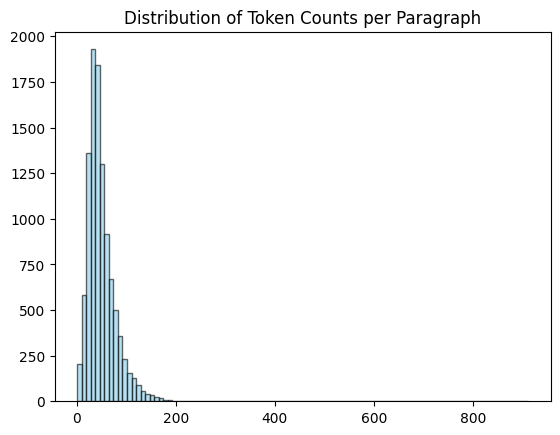

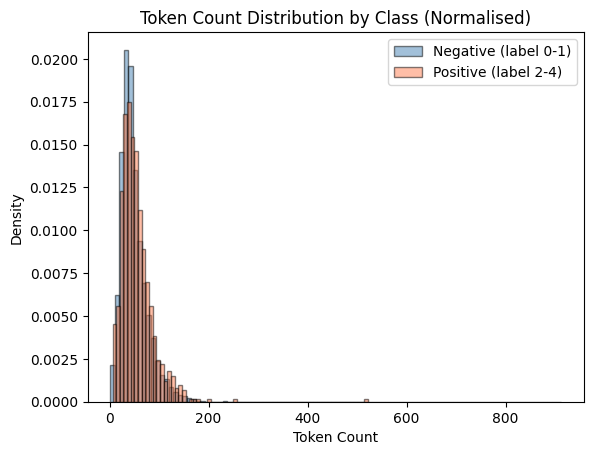

In [4]:
# Histogram for token count per paragraph.
token_counts = [len(para) for para in paras]
min_tokens = min(token_counts)
max_tokens = max(token_counts)
median_tokens = sorted(token_counts)[len(token_counts) // 2]
mode_tokens = max(set(token_counts), key=token_counts.count)
average_tokens = sum(token_counts) / len(token_counts)

print(f"Minimum number of tokens in a paragraph: {min_tokens}. Count: {token_counts.count(min_tokens)}")
print(f"Maximum number of tokens in a paragraph: {max_tokens}. Count: {token_counts.count(max_tokens)}")
print(f"Median number of tokens in a paragraph: {median_tokens}.")
print(f"Mode number of tokens in a paragraph: {mode_tokens}")
print(f"Average number of tokens in a paragraph: {average_tokens:.2f}")
plt.hist(token_counts, bins=100, color="skyblue", edgecolor="black", alpha=0.6)
plt.title("Distribution of Token Counts per Paragraph")
plt.show()

# Overlapping histogram by class
labels = doc_df["label"].values
neg_token_counts = [len(para) for para, label in zip(paras, labels) if label < 2]
pos_token_counts = [len(para) for para, label in zip(paras, labels) if label >= 2]

plt.hist(neg_token_counts, bins=100, density=True, color="steelblue", edgecolor="black", alpha=0.5, label="Negative (label 0-1)")
plt.hist(pos_token_counts, bins=70, density=True, color="coral", edgecolor="black", alpha=0.5, label="Positive (label 2-4)")
plt.title("Token Count Distribution by Class (Normalised)")
plt.xlabel("Token Count")
plt.ylabel("Density")
plt.legend()
plt.show()

In [5]:
vocab_size = len(nlp.vocab)
print(f"Vocabulary size: {vocab_size}")

classes = doc_df["label"].value_counts()
negative  = classes.get(0, 0) + classes.get(1, 0)
positive = classes.get(2, 0) + classes.get(3, 0) + classes.get(4, 0)
percentage_positive = positive / (negative + positive) * 100
assert negative + positive == len(doc_df), "The sum of negative and positive samples does not match the total number of documents."
print(f"{negative} negative and {positive} positive for PCL, {percentage_positive:.2f}% positive.")

classes_per_category = doc_df[["label", "keyword", "country_code"]].value_counts()
negative_per_category = classes_per_category[classes_per_category.index.get_level_values("label") <= 1].groupby(["keyword", "country_code"]).sum()
positive_per_category = classes_per_category[classes_per_category.index.get_level_values("label") >= 2].groupby(["keyword", "country_code"]).sum()


Vocabulary size: 35495
9475 negative and 993 positive for PCL, 9.49% positive.


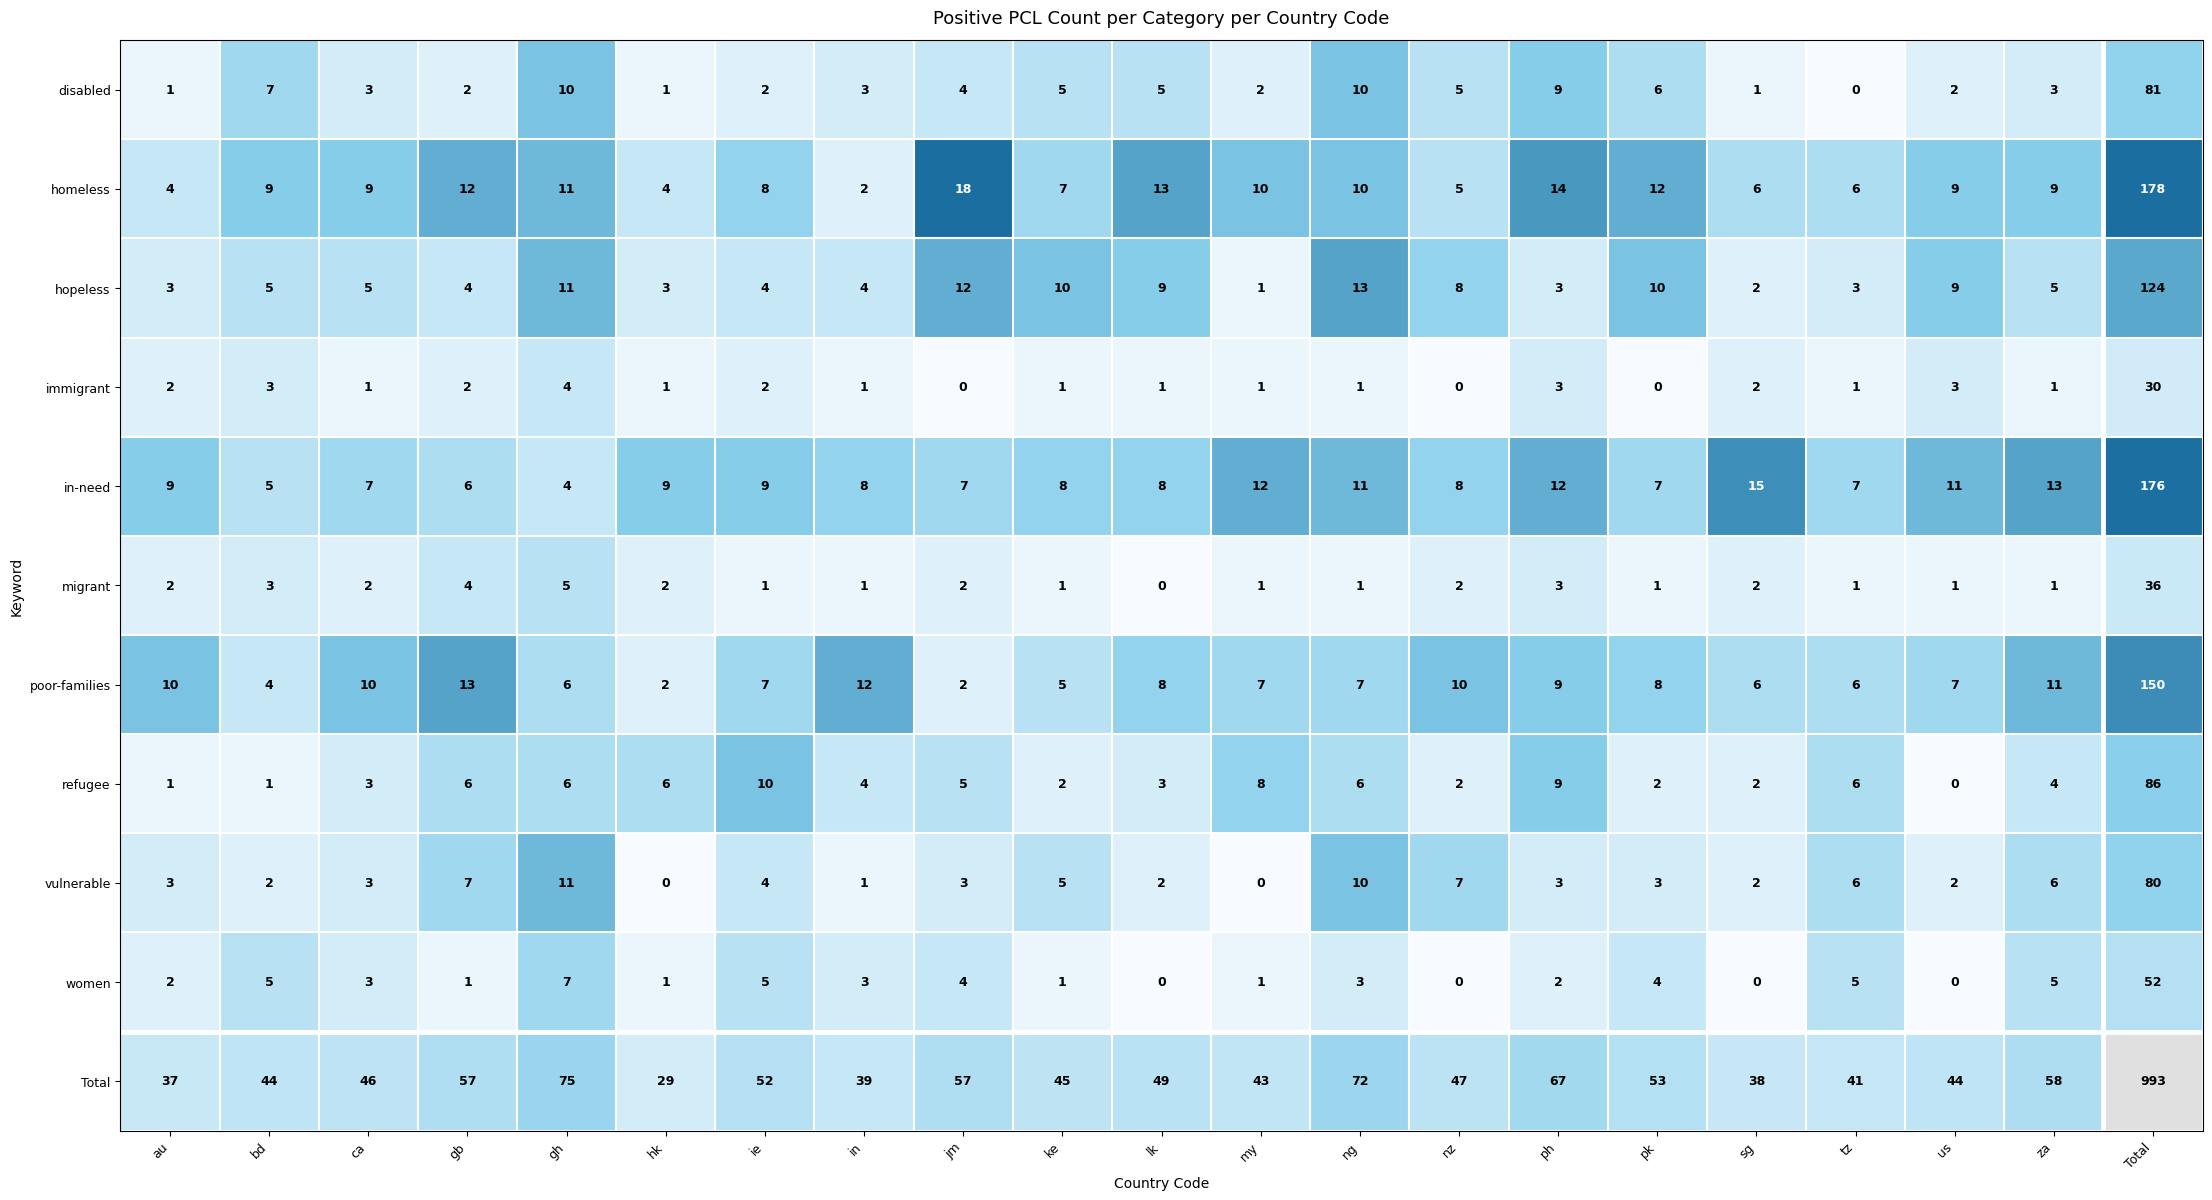

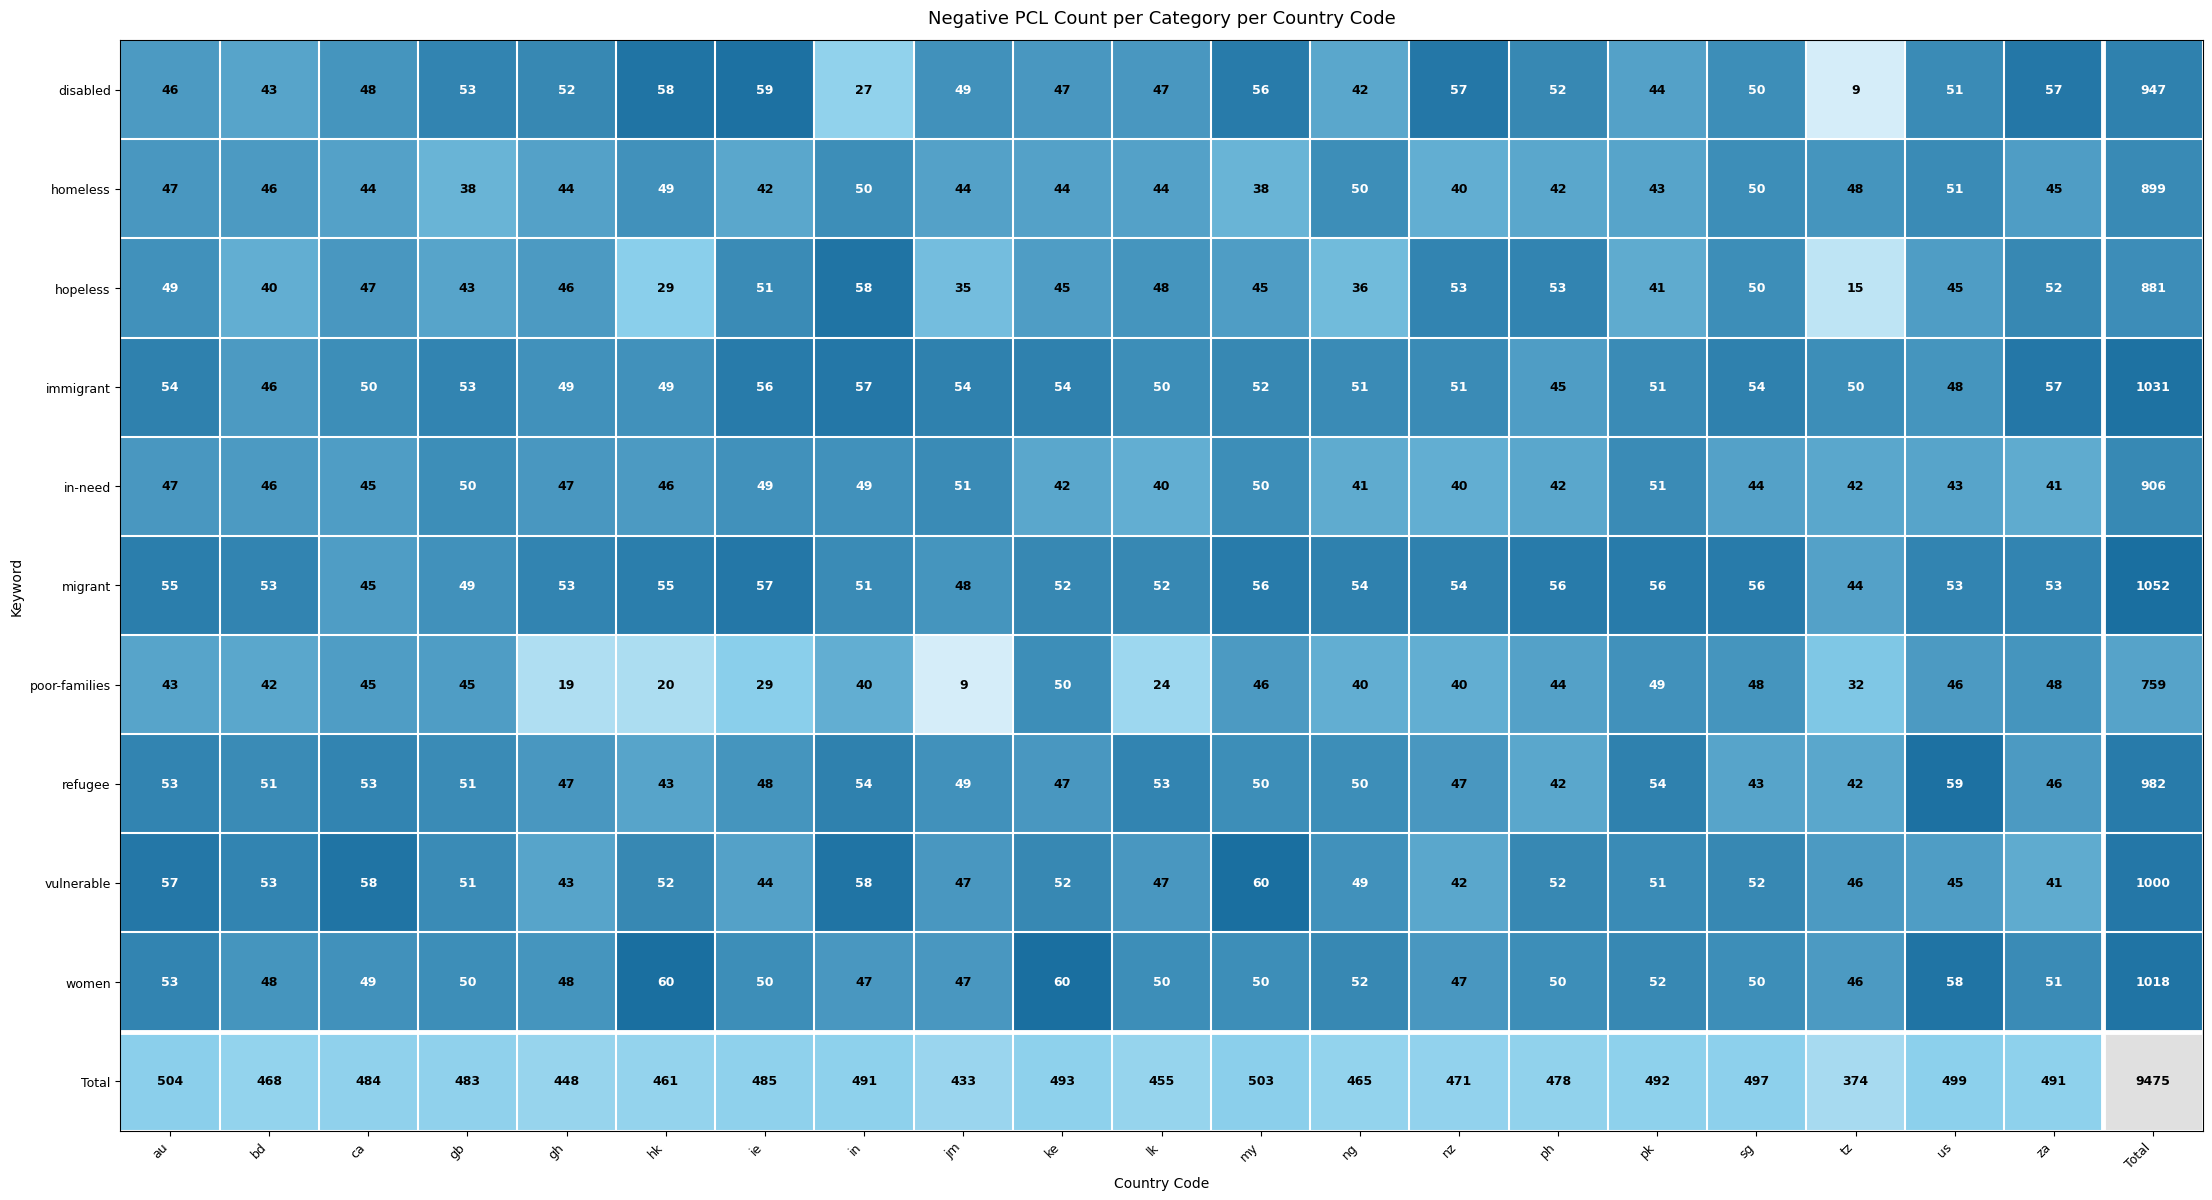

In [6]:
def plot_category_country_heatmap(per_category_series, title):
    """Plot a heatmap grid of counts per keyword x country_code with totals."""
    pivot = per_category_series.unstack(fill_value=0)
    pivot["Total"] = pivot.sum(axis=1)
    total_row = pivot.sum(axis=0); total_row.name = "Total"
    pivot = pd.concat([pivot, total_row.to_frame().T])

    data = pivot.values.astype(int)
    rows, cols = list(pivot.index), list(pivot.columns)
    nr, nc = len(rows), len(cols)

    cmap = mcolors.LinearSegmentedColormap.from_list("sky", ["#f7fbff", "#87CEEB", "#1a6fa0"])
    d_norm = mcolors.Normalize(0, max(data[:-1, :-1].max(), 1))
    t_norm = mcolors.Normalize(0, max(np.concatenate([data[-1, :-1], data[:-1, -1]]).max(), 1))

    # Build RGBA colour matrix (vectorised — no loop for colouring)
    rgba = np.zeros((nr, nc, 4))
    rgba[:-1, :-1] = cmap(d_norm(data[:-1, :-1].astype(float)))
    rgba[-1, :-1] = cmap(t_norm(data[-1, :-1].astype(float)))
    rgba[:-1, -1] = cmap(t_norm(data[:-1, -1].astype(float)))
    rgba[-1, -1] = mcolors.to_rgba("#e0e0e0")

    fig, ax = plt.subplots(figsize=(nc + 1.5, nr + 1))
    ax.imshow(rgba, aspect="equal")

    # Grid lines; thick separator before totals
    for k in range(nr + 1):
        ax.axhline(k - 0.5, color="white", lw=3.5 if k == nr - 1 else 1.5)
    for k in range(nc + 1):
        ax.axvline(k - 0.5, color="white", lw=3.5 if k == nc - 1 else 1.5)

    # Text annotations
    for i in range(nr):
        for j in range(nc):
            lum = rgba[i, j, :3] @ [.299, .587, .114]
            ax.text(j, i, str(data[i, j]), ha="center", va="center",
                    fontsize=9, fontweight="bold", color="white" if lum < .5 else "black")

    ax.set_xticks(range(nc)); ax.set_xticklabels(cols, rotation=45, ha="right", fontsize=9)
    ax.set_yticks(range(nr)); ax.set_yticklabels(rows, fontsize=9)
    ax.set_title(title, fontsize=13, pad=12)
    ax.set_xlabel("Country Code"); ax.set_ylabel("Keyword")
    plt.tight_layout(); plt.show()

plot_category_country_heatmap(positive_per_category, "Positive PCL Count per Category per Country Code")
plot_category_country_heatmap(negative_per_category, "Negative PCL Count per Category per Country Code")

## Identifying Noise and Artifacts
We will firstly check for duplicated entries in the data, then see if there are any hidden HTML tags or tokens like "\n" that may confuse a tokeniser.
Finally we will analyse the outliers identified in paragraph token analysis.

In [7]:
doc_df[doc_df.duplicated(subset=["text"])]
# No duplicated rows!

,art_id,keyword,country_code,text,label
par_id,,,,,


In [8]:
matches = 0
doc_matches = set()
tags = set()
for row in doc_df.itertuples():
    para = str(row.text)
    for match in re.finditer(r"<[^>]+>|<\/[^>]+>|&\w+;|\n|\\n|\s{2,}|\r|\\r|@@\d+|[^\x00-\x7F]+|https?://\S+", para):
        tags.add(match.group())
        doc_matches.add(row.Index)
        matches += 1
print(f"Found {matches} HTML/special tags in {len(doc_matches)} documents."
      f"Percentage of documents with HTML/special tags: {len(doc_matches)/len(docs_list)*100:.2f}%")
print(f"Unique HTML/special tags found: {tags}")
# Only <h>, &gt, and &amp found, should be okay to remove.

Found 614 HTML/special tags in 469 documents.Percentage of documents with HTML/special tags: 4.48%
Unique HTML/special tags found: {'&amp;', '@@7039594', '&gt;', '<h>', '@@7022812'}


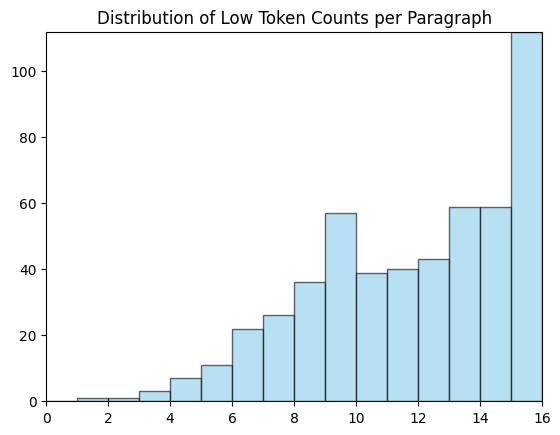

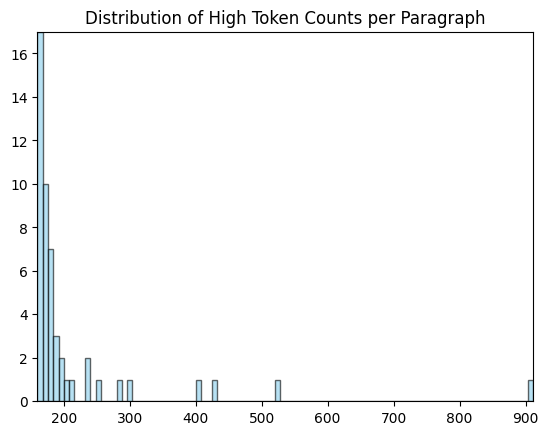

In [9]:
high_range = (160, max_tokens)
low_range = (0, 16)

plt.margins(x=0, y=0)
plt.hist(token_counts, bins=low_range[1]-low_range[0], color="skyblue", edgecolor="black", alpha=0.6, range=low_range)
plt.title("Distribution of Low Token Counts per Paragraph")
plt.show()
plt.margins(x=0, y=0)
plt.hist(token_counts, bins=(high_range[1]-high_range[0])//8, color="skyblue", edgecolor="black", alpha=0.6, range=high_range)
plt.title("Distribution of High Token Counts per Paragraph")
plt.show()

In [10]:

def pos_neg_in_tok_range(range: tuple[int, int]) -> tuple[int, int]:
    pos = 0
    neg = 0
    for row, para in zip(doc_df.itertuples(), paras):
        token_count = len(para)
        if token_count >= range[0] and token_count <= range[1]:
            assert row.text == para.text
            if row.label >= 2:
                pos += 1
            else:
                neg += 1
    return pos, neg

pos_low, neg_low = pos_neg_in_tok_range(low_range)
pos_high, neg_high = pos_neg_in_tok_range(high_range)
print(f"Low token count range {low_range} has {pos_low} positive and {neg_low} negative for PCL. Percentage positive:\t{pos_low/(pos_low+neg_low)*100:.2f}%")
print(f"High token count range {high_range} has {pos_high} positive and {neg_high} negative for PCL. Percentage positive:\t{pos_high/(pos_high+neg_high)*100:.2f}%")
print(f"Overall percentage positive:\t{percentage_positive:.2f}%")


Low token count range (0, 16) has 45 positive and 471 negative for PCL. Percentage positive:	8.72%
High token count range (160, 912) has 6 positive and 44 negative for PCL. Percentage positive:	12.00%
Overall percentage positive:	9.49%


## Semantic and Syntactic Exploration

First we will do POS tagging, then NER, then an embedding visualisation of words coloured by class.

POS Tag      Neg (prop)   Pos (prop)  Diff (Pos-Neg)
----------------------------------------------------
NOUN             0.2281       0.2164         -0.0117
VERB             0.1200       0.1302         +0.0101
ADP              0.1303       0.1277         -0.0026
ADJ              0.0889       0.0867         -0.0022
DET              0.0879       0.0899         +0.0020
AUX              0.0538       0.0561         +0.0023
PROPN            0.0930       0.0742         -0.0188
PRON             0.0566       0.0794         +0.0228
CCONJ            0.0323       0.0369         +0.0046
ADV              0.0361       0.0352         -0.0008
PART             0.0280       0.0340         +0.0060
SCONJ            0.0180       0.0179         -0.0001
NUM              0.0215       0.0099         -0.0116
X                0.0047       0.0051         +0.0004
INTJ             0.0004       0.0004         -0.0000
SYM              0.0004       0.0002         -0.0002
PUNCT            0.0001       0.0000         -

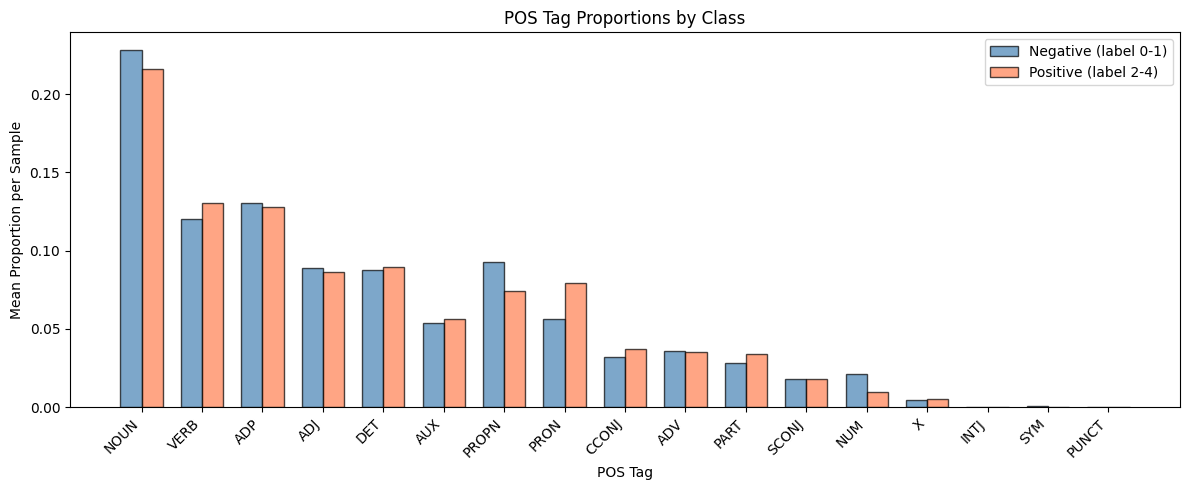


Nouns (NOUN+PROPN): 142961
Verbs (VERB+AUX):  80284
Adjectives:        39645
Adverbs:           17161
Noun-to-Verb ratio: 1.78


In [11]:
from collections import Counter

# Count POS tags per document as proportions of document length, then compute mean per class
labels = doc_df["label"].values

# Build per-document POS proportions
prop_per_doc_neg = []  # list of dicts, one per negative sample
prop_per_doc_pos = []  # list of dicts, one per positive sample

for para, label in zip(paras, labels):
    doc_pos = Counter()
    for token in para:
        if not token.is_punct and not token.is_space:
            doc_pos[token.pos_] += 1
    total_tokens = sum(doc_pos.values())
    if total_tokens > 0:
        doc_prop = {tag: count / total_tokens for tag, count in doc_pos.items()}
    else:
        doc_prop = {}
    if label >= 2:
        prop_per_doc_pos.append(doc_prop)
    else:
        prop_per_doc_neg.append(doc_prop)

# Get all POS tags sorted by overall total frequency
pos_counts_total = Counter()
for d in prop_per_doc_neg + prop_per_doc_pos:
    for tag in d:
        pos_counts_total[tag] += 1
# Sort by how many documents contain each tag (descending)
all_tags = [tag for tag, _ in pos_counts_total.most_common()]

# Compute mean proportion per class
neg_means = {tag: np.mean([d.get(tag, 0.0) for d in prop_per_doc_neg]) for tag in all_tags}
pos_means = {tag: np.mean([d.get(tag, 0.0) for d in prop_per_doc_pos]) for tag in all_tags}

neg_props = [neg_means[tag] for tag in all_tags]
pos_props = [pos_means[tag] for tag in all_tags]

# Print table
print(f"{'POS Tag':<10} {'Neg (prop)':>12} {'Pos (prop)':>12} {'Diff (Pos-Neg)':>15}")
print("-" * 52)
for tag, nn, pn in zip(all_tags, neg_props, pos_props):
    print(f"{tag:<10} {nn:>12.4f} {pn:>12.4f} {pn - nn:>+15.4f}")

# Grouped bar chart (proportions)
x = np.arange(len(all_tags))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - width/2, neg_props, width, label="Negative (label 0-1)", color="steelblue", edgecolor="black", alpha=0.7)
ax.bar(x + width/2, pos_props, width, label="Positive (label 2-4)", color="coral", edgecolor="black", alpha=0.7)
ax.set_xlabel("POS Tag")
ax.set_ylabel("Mean Proportion per Sample")
ax.set_title("POS Tag Proportions by Class")
ax.set_xticks(x)
ax.set_xticklabels(all_tags, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

fig.savefig(f"{OUT_PATH}/pos_tagging.svg", format="svg")
fig.savefig(f"{OUT_PATH}/pos_tagging.png", dpi=400)

# Noun vs Verb comparison (using raw totals)
pos_counts_raw = Counter()
for para in paras:
    for token in para:
        if not token.is_punct and not token.is_space:
            pos_counts_raw[token.pos_] += 1
nouns = pos_counts_raw.get("NOUN", 0) + pos_counts_raw.get("PROPN", 0)
verbs = pos_counts_raw.get("VERB", 0) + pos_counts_raw.get("AUX", 0)
adjs = pos_counts_raw.get("ADJ", 0)
advs = pos_counts_raw.get("ADV", 0)
print(f"\nNouns (NOUN+PROPN): {nouns}")
print(f"Verbs (VERB+AUX):  {verbs}")
print(f"Adjectives:        {adjs}")
print(f"Adverbs:           {advs}")
print(f"Noun-to-Verb ratio: {nouns/verbs:.2f}")

Entity Type    Neg (prop)   Pos (prop)  Diff (Pos-Neg)
------------------------------------------------------
ORG                0.1766       0.1660         -0.0106
GPE                0.1551       0.1262         -0.0289
PERSON             0.1408       0.1709         +0.0301
DATE               0.1184       0.1149         -0.0035
CARDINAL           0.1127       0.0835         -0.0292
NORP               0.0724       0.0676         -0.0048
LOC                0.0187       0.0179         -0.0008
ORDINAL            0.0158       0.0169         +0.0011
MONEY              0.0088       0.0067         -0.0021
TIME               0.0079       0.0106         +0.0027
FAC                0.0065       0.0071         +0.0006
WORK_OF_ART        0.0067       0.0098         +0.0031
PERCENT            0.0090       0.0027         -0.0063
EVENT              0.0039       0.0042         +0.0003
QUANTITY           0.0039       0.0049         +0.0011
PRODUCT            0.0031       0.0017         -0.0014
LAW       

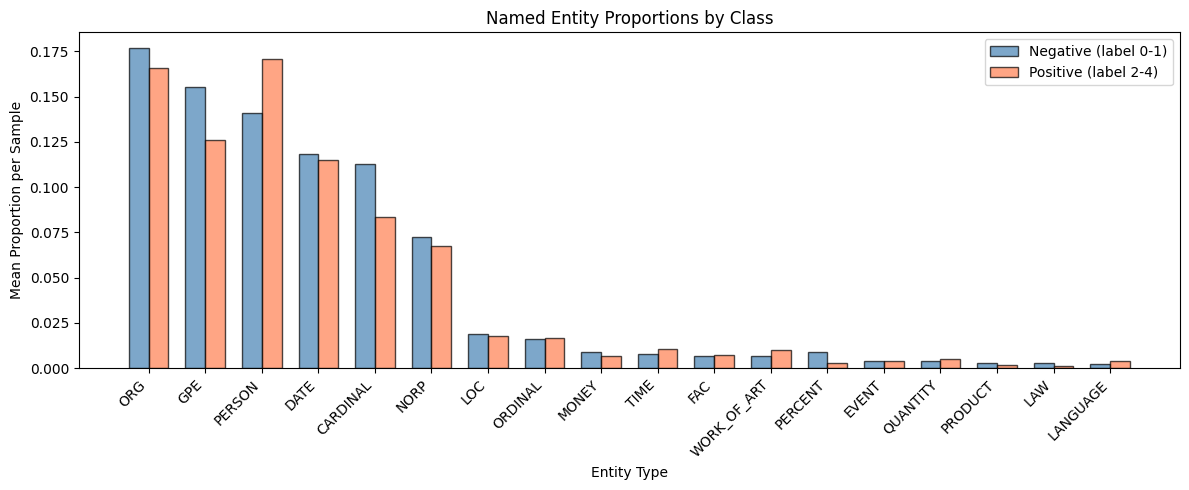


  ORG
             Negative             |             Positive           
  Entity                  Count  |  Entity                  Count
  ------------------------------  |  ------------------------------
  UN                        128  |  UN                         10
  Trump                     127  |  UNHCR                       6
  EU                         96  |  IRC                         5
  UNHCR                      59  |  Group                       4
  Congress                   43  |  Congress                    4

  GPE
             Negative             |             Positive           
  Entity                  Count  |  Entity                  Count
  ------------------------------  |  ------------------------------
  US                        288  |  Nigeria                    15
  Bangladesh                151  |  America                    14
  India                     145  |  Pakistan                   12
  the United States         127  |  India             

In [12]:
# Named Entity Recognition - per-document proportions by class
labels = doc_df["label"].values

# Count NER types per document as proportion of total entities, then mean per class
ner_per_doc_neg = []
ner_per_doc_pos = []

for para, label in zip(paras, labels):
    doc_ner = Counter()
    for ent in para.ents:
        doc_ner[ent.label_] += 1
    total_ents = sum(doc_ner.values())
    if total_ents > 0:
        doc_prop = {tag: count / total_ents for tag, count in doc_ner.items()}
    else:
        doc_prop = {}
    if label >= 2:
        ner_per_doc_pos.append(doc_prop)
    else:
        ner_per_doc_neg.append(doc_prop)

# Get all entity types sorted by frequency of appearance across documents
ner_type_freq = Counter()
for d in ner_per_doc_neg + ner_per_doc_pos:
    for tag in d:
        ner_type_freq[tag] += 1
all_ner_tags = [tag for tag, _ in ner_type_freq.most_common()]

# Compute mean proportion per class
ner_neg_means = {tag: np.mean([d.get(tag, 0.0) for d in ner_per_doc_neg]) for tag in all_ner_tags}
ner_pos_means = {tag: np.mean([d.get(tag, 0.0) for d in ner_per_doc_pos]) for tag in all_ner_tags}

ner_neg_props = [ner_neg_means[tag] for tag in all_ner_tags]
ner_pos_props = [ner_pos_means[tag] for tag in all_ner_tags]

# Print proportion table
print(f"{'Entity Type':<12} {'Neg (prop)':>12} {'Pos (prop)':>12} {'Diff (Pos-Neg)':>15}")
print("-" * 54)
for tag, nn, pn in zip(all_ner_tags, ner_neg_props, ner_pos_props):
    print(f"{tag:<12} {nn:>12.4f} {pn:>12.4f} {pn - nn:>+15.4f}")

# Grouped bar chart (proportions)
x = np.arange(len(all_ner_tags))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 5))
ax.bar(x - width/2, ner_neg_props, width, label="Negative (label 0-1)", color="steelblue", edgecolor="black", alpha=0.7)
ax.bar(x + width/2, ner_pos_props, width, label="Positive (label 2-4)", color="coral", edgecolor="black", alpha=0.7)
ax.set_xlabel("Entity Type")
ax.set_ylabel("Mean Proportion per Sample")
ax.set_title("Named Entity Proportions by Class")
ax.set_xticks(x)
ax.set_xticklabels(all_ner_tags, rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

fig.savefig(f"{OUT_PATH}/ner.svg", format="svg")
fig.savefig(f"{OUT_PATH}/ner.png", dpi=400)

# Top entities per type, split by class, shown side-by-side
TOP_N = 5
for ner_label in all_ner_tags:
    neg_ents = Counter()
    pos_ents = Counter()
    for para, label in zip(paras, labels):
        for ent in para.ents:
            if ent.label_ == ner_label:
                text = ent.text.strip()
                if label >= 2:
                    pos_ents[text] += 1
                else:
                    neg_ents[text] += 1
    if not neg_ents and not pos_ents:
        continue
    neg_top = neg_ents.most_common(TOP_N)
    pos_top = pos_ents.most_common(TOP_N)
    # Pad shorter list
    while len(neg_top) < TOP_N:
        neg_top.append(("", 0))
    while len(pos_top) < TOP_N:
        pos_top.append(("", 0))

    print(f"\n{'=' * 70}")
    print(f"  {ner_label}")
    print(f"{'=' * 70}")
    print(f"  {'Negative':^30}  |  {'Positive':^30}")
    print(f"  {'Entity':<22} {'Count':>6}  |  {'Entity':<22} {'Count':>6}")
    print(f"  {'-'*30}  |  {'-'*30}")
    for (n_name, n_count), (p_name, p_count) in zip(neg_top, pos_top):
        n_str = f"{n_name:<22} {n_count:>6}" if n_name else f"{'':>30}"
        p_str = f"{p_name:<22} {p_count:>6}" if p_name else f"{'':>30}"
        print(f"  {n_str}  |  {p_str}")

Words with >= 20 occurrences and non-zero vectors: 2184
  Positive-leaning: 961, Negative-leaning: 1223


/tmp/ipykernel_2413/2541562242.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(f"{OUT_PATH}/tsne_embeddings.svg", format="svg")


Saved out/tsne_embeddings.svg and out/tsne_embeddings.png (400 dpi)


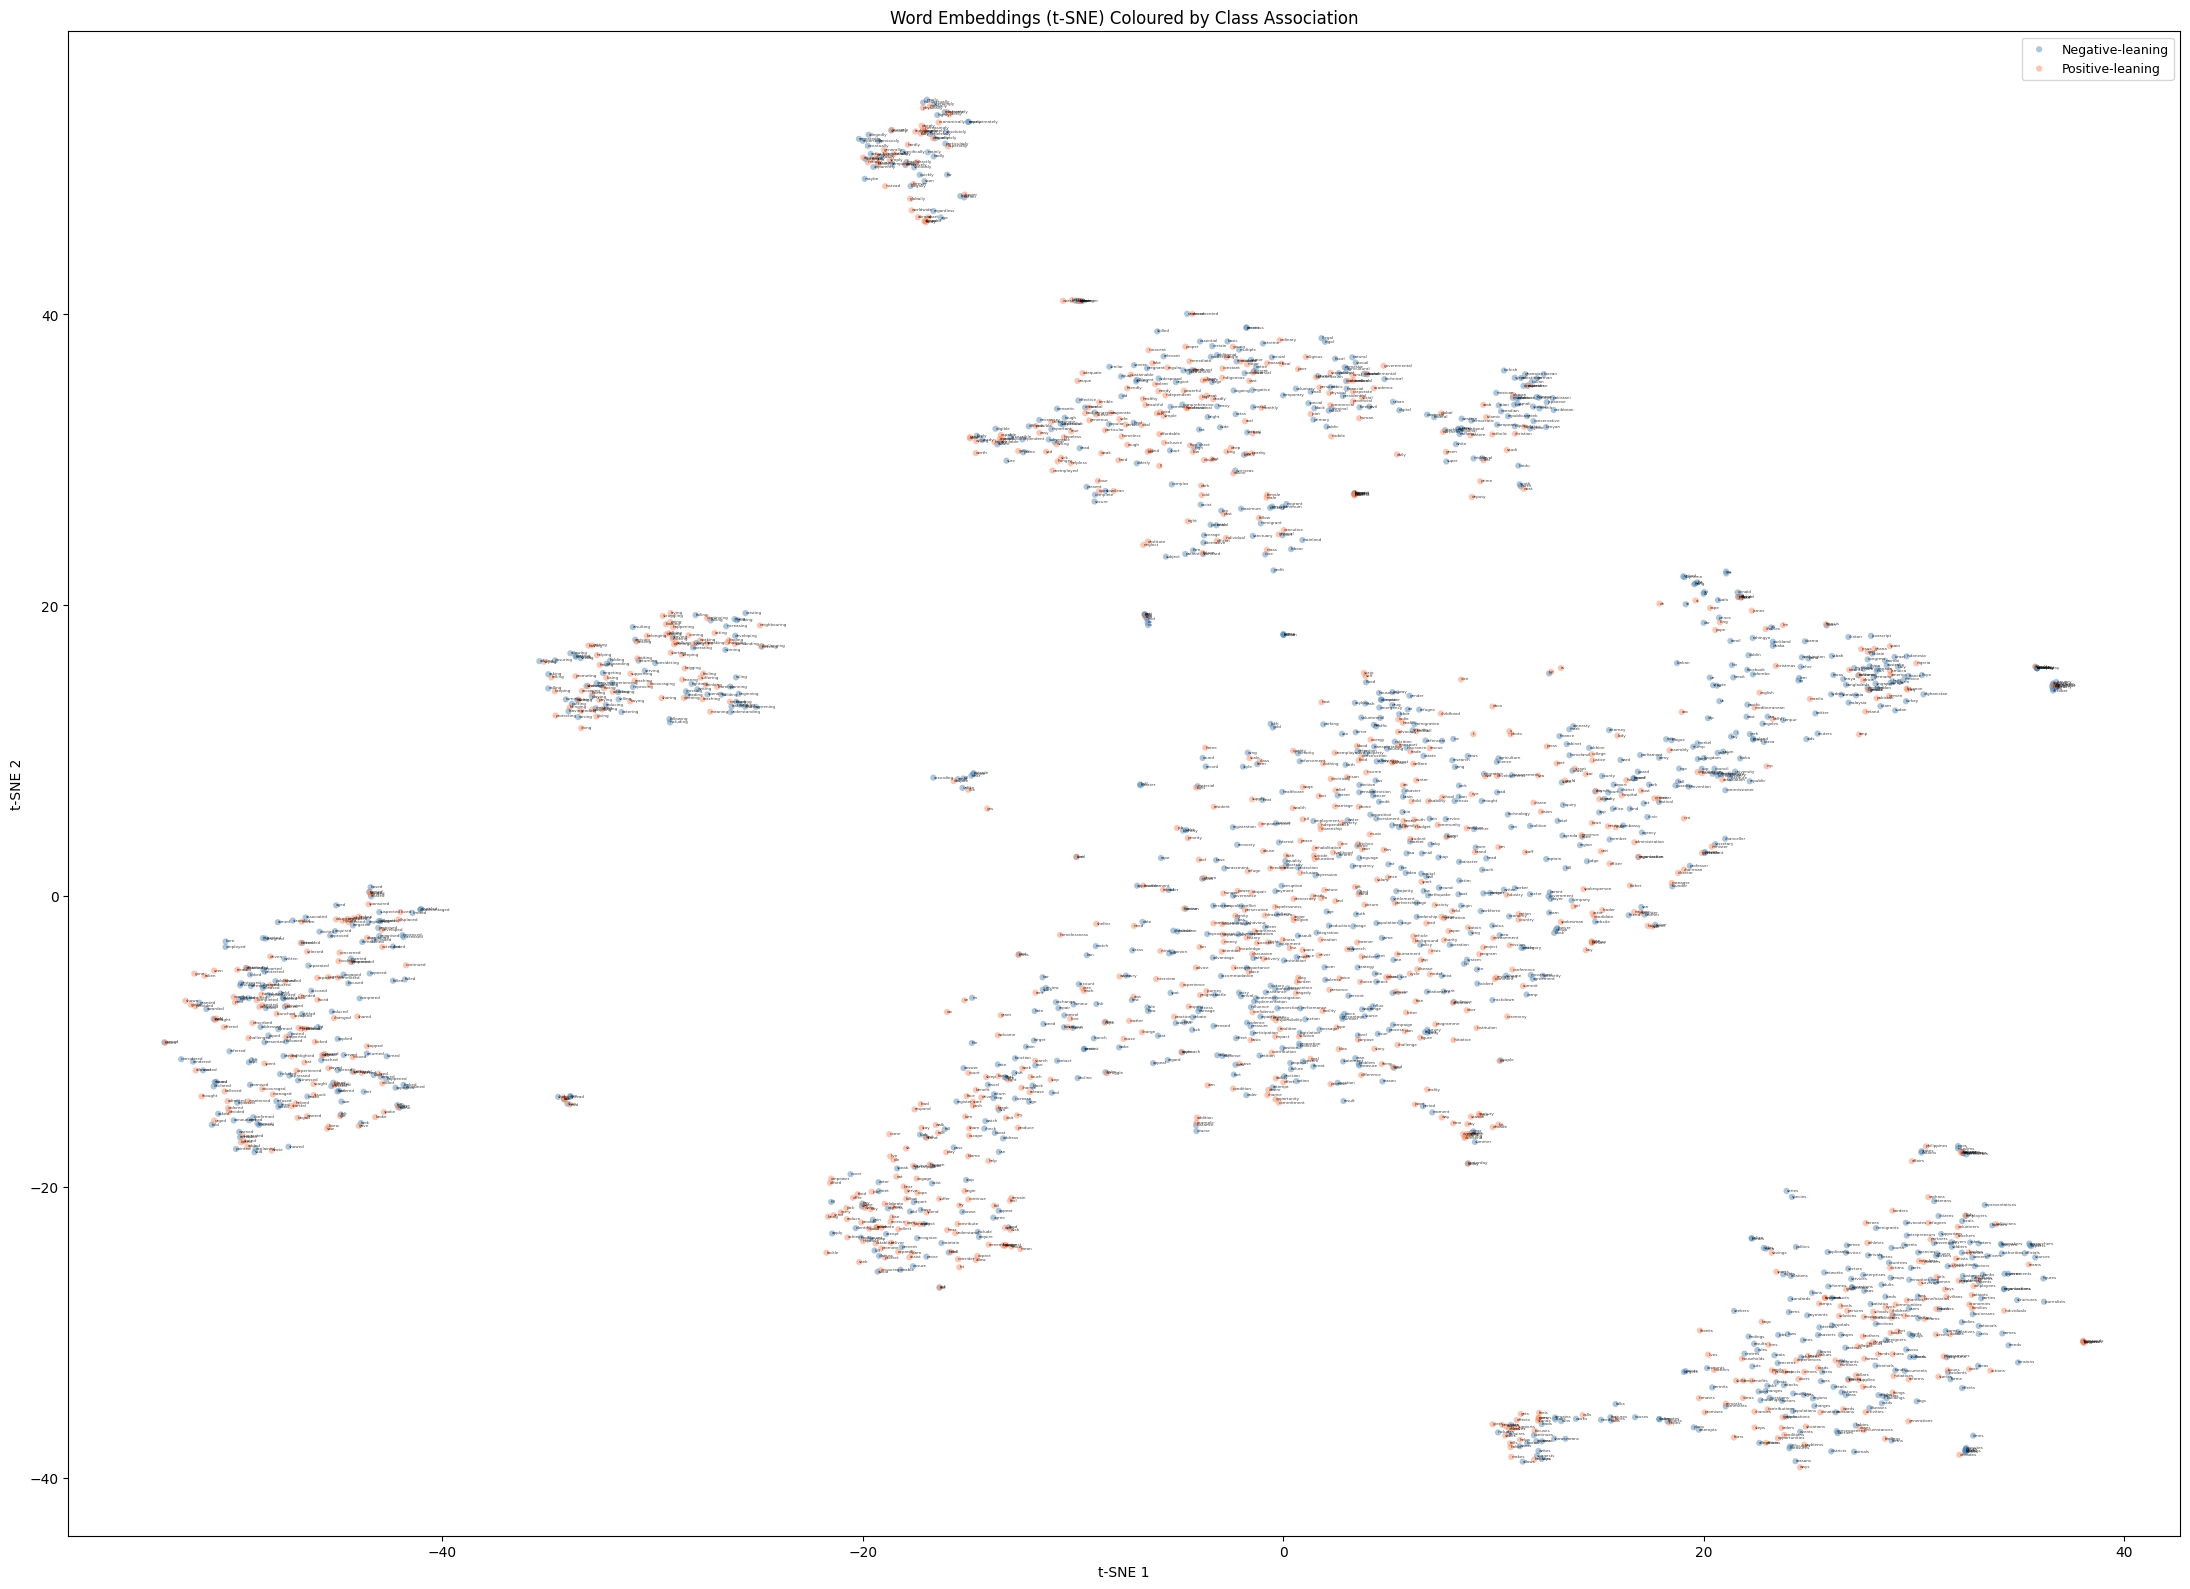

In [13]:
from sklearn.manifold import TSNE

# Build word vectors averaged across all occurrences, tracking class association
# For each word, average its tok2vec vectors and track positive vs negative frequency
labels = doc_df["label"].values
word_vectors = {}   # word -> list of vectors (to average)
word_pos_freq = Counter()  # word -> count in positive docs
word_neg_freq = Counter()  # word -> count in negative docs

for para, label in zip(paras, labels):
    is_pos = label >= 2
    for token in para:
        if token.is_punct or token.is_space or token.is_stop or not token.is_alpha:
            continue
        w = token.lower_
        if w not in word_vectors:
            word_vectors[w] = []
        word_vectors[w].append(token.vector)
        if is_pos:
            word_pos_freq[w] += 1
        else:
            word_neg_freq[w] += 1

# Average vectors per word and filter to words with enough occurrences
MIN_FREQ = 20
words, vecs, colours = [], [], []
for w, vec_list in word_vectors.items():
    total_freq = word_pos_freq[w] + word_neg_freq[w]
    if total_freq < MIN_FREQ:
        continue
    avg_vec = np.mean(vec_list, axis=0)
    if np.linalg.norm(avg_vec) == 0:
        continue
    words.append(w)
    vecs.append(avg_vec)
    # Colour by which class uses the word proportionally more
    # Normalise by class size to get rate, then compare
    pos_rate = word_pos_freq[w] / positive
    neg_rate = word_neg_freq[w] / negative
    colours.append("coral" if pos_rate > neg_rate else "steelblue")

print(f"Words with >= {MIN_FREQ} occurrences and non-zero vectors: {len(words)}")
print(f"  Positive-leaning: {colours.count('coral')}, Negative-leaning: {colours.count('steelblue')}")

# t-SNE to 2D
vecs_arr = np.array(vecs)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
coords = tsne.fit_transform(vecs_arr)

# Plot – label every word, save as SVG for lossless zoom
fig, ax = plt.subplots(figsize=(22, 16))
for colour_val, label_text in [("steelblue", "Negative-leaning"), ("coral", "Positive-leaning")]:
    mask = [c == colour_val for c in colours]
    ax.scatter(coords[mask, 0], coords[mask, 1], c=colour_val, alpha=0.45, s=20, label=label_text, edgecolors="none")

# Label ALL words above MIN_FREQ
for i, w in enumerate(words):
    ax.annotate(w, (coords[i, 0], coords[i, 1]), fontsize=3, alpha=0.75)

ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.set_title("Word Embeddings (t-SNE) Coloured by Class Association")
ax.legend(fontsize=9)
plt.tight_layout()

# Save vector SVG (infinite zoom, all labels crisp) + high-res PNG
fig.savefig(f"{OUT_PATH}/tsne_embeddings.svg", format="svg")
fig.savefig(f"{OUT_PATH}/tsne_embeddings.png", dpi=400)
print(f"Saved {OUT_PATH}/tsne_embeddings.svg and {OUT_PATH}/tsne_embeddings.png (400 dpi)")

plt.show()

N-grams with >= 10 occurrences: 9344

Top 30 n-grams most associated with POSITIVE (PCL) class:
  N-gram                            z-score   log-odds   pos_freq   neg_freq
  ------------------------------------------------------------------------
  life                                +5.44    +0.2720        164        379
  help                                +4.95    +0.2131        191        547
  christmas                           +4.22    +0.7306         29         16
  we                                  +4.13    +0.1159        333       1435
  hope                                +4.08    +0.3454         67        121
  hungry                              +3.95    +0.8016         23         10
  god                                 +3.95    +0.5374         36         36
  poor                                +3.78    +0.1271        242        990
  give                                +3.67    +0.1795        135        441
  our                                 +3.60    +0.1589     

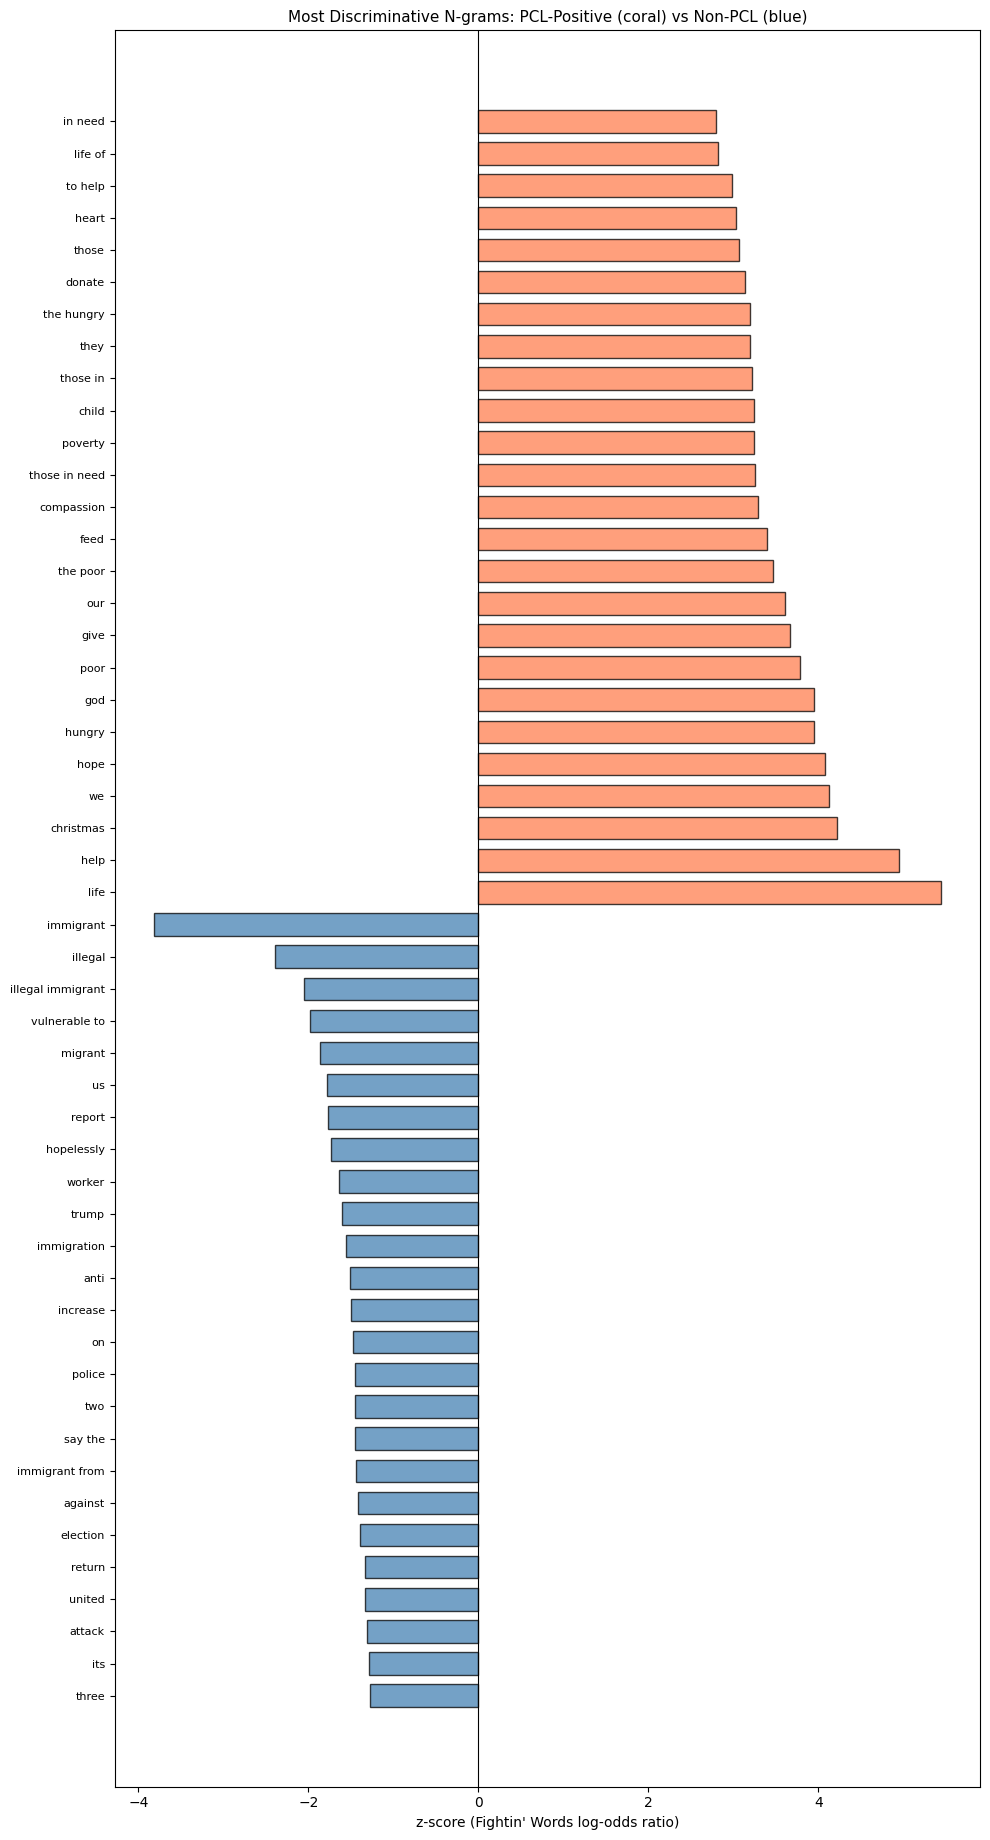

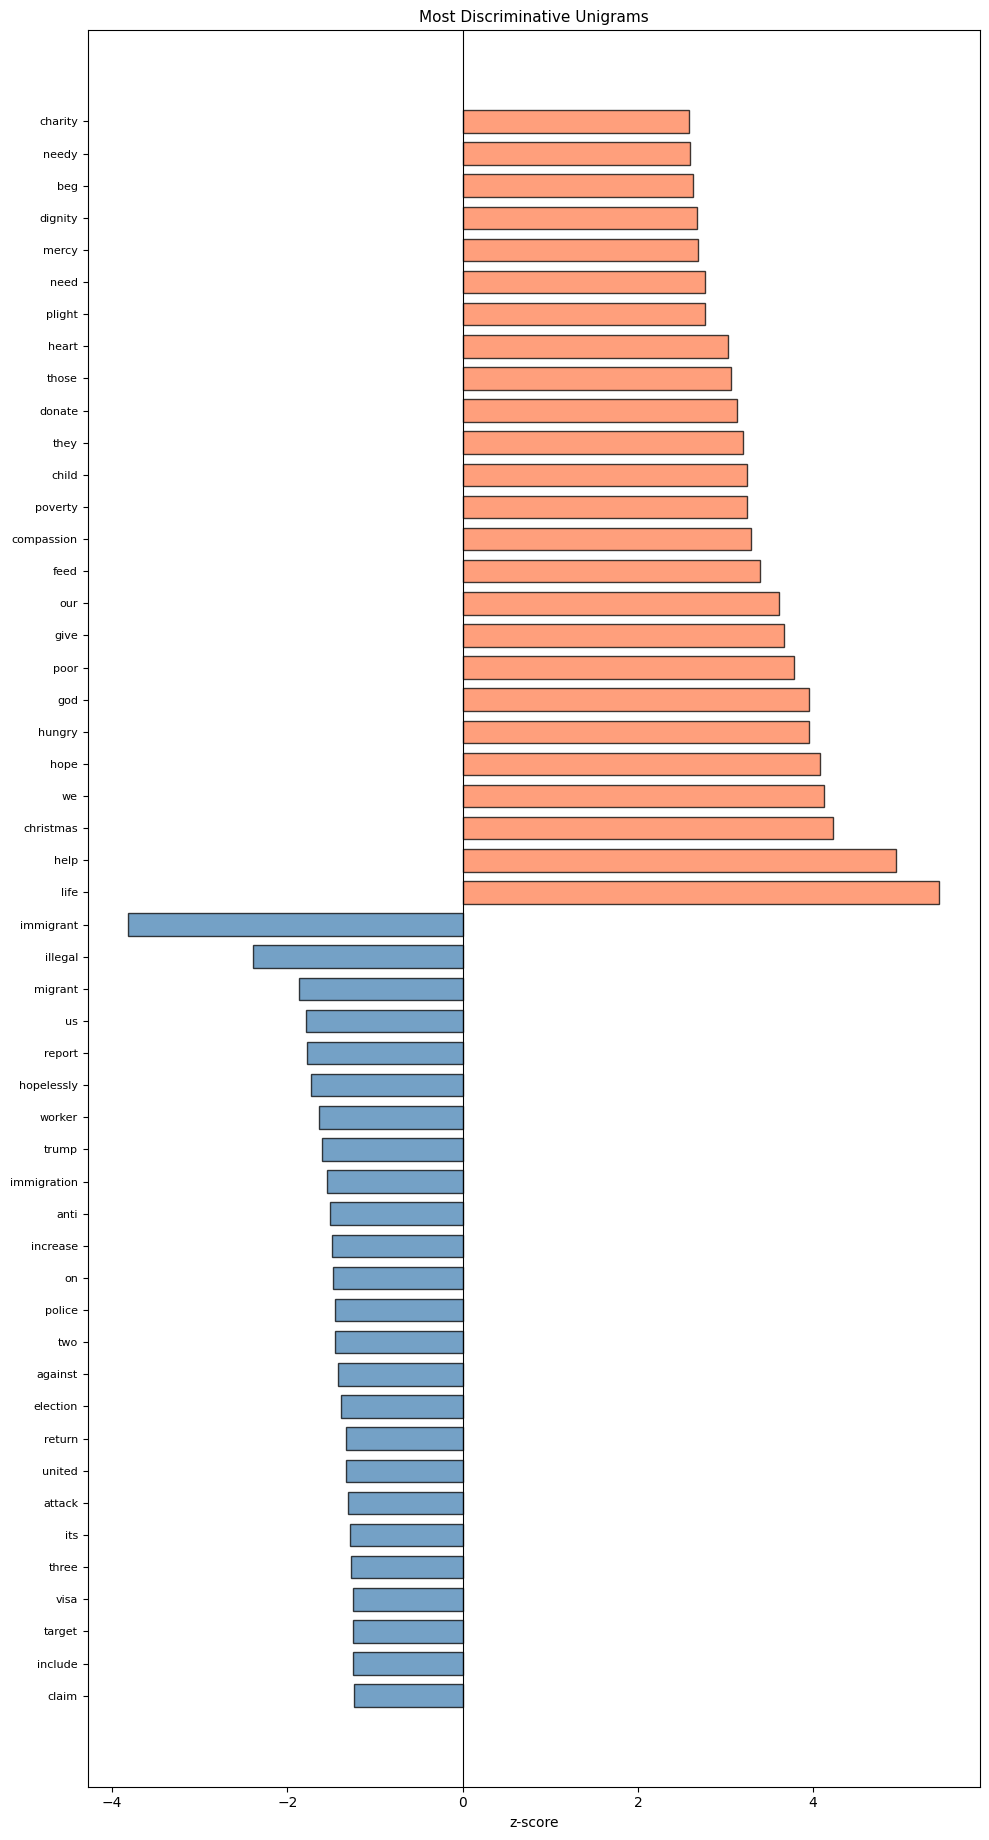

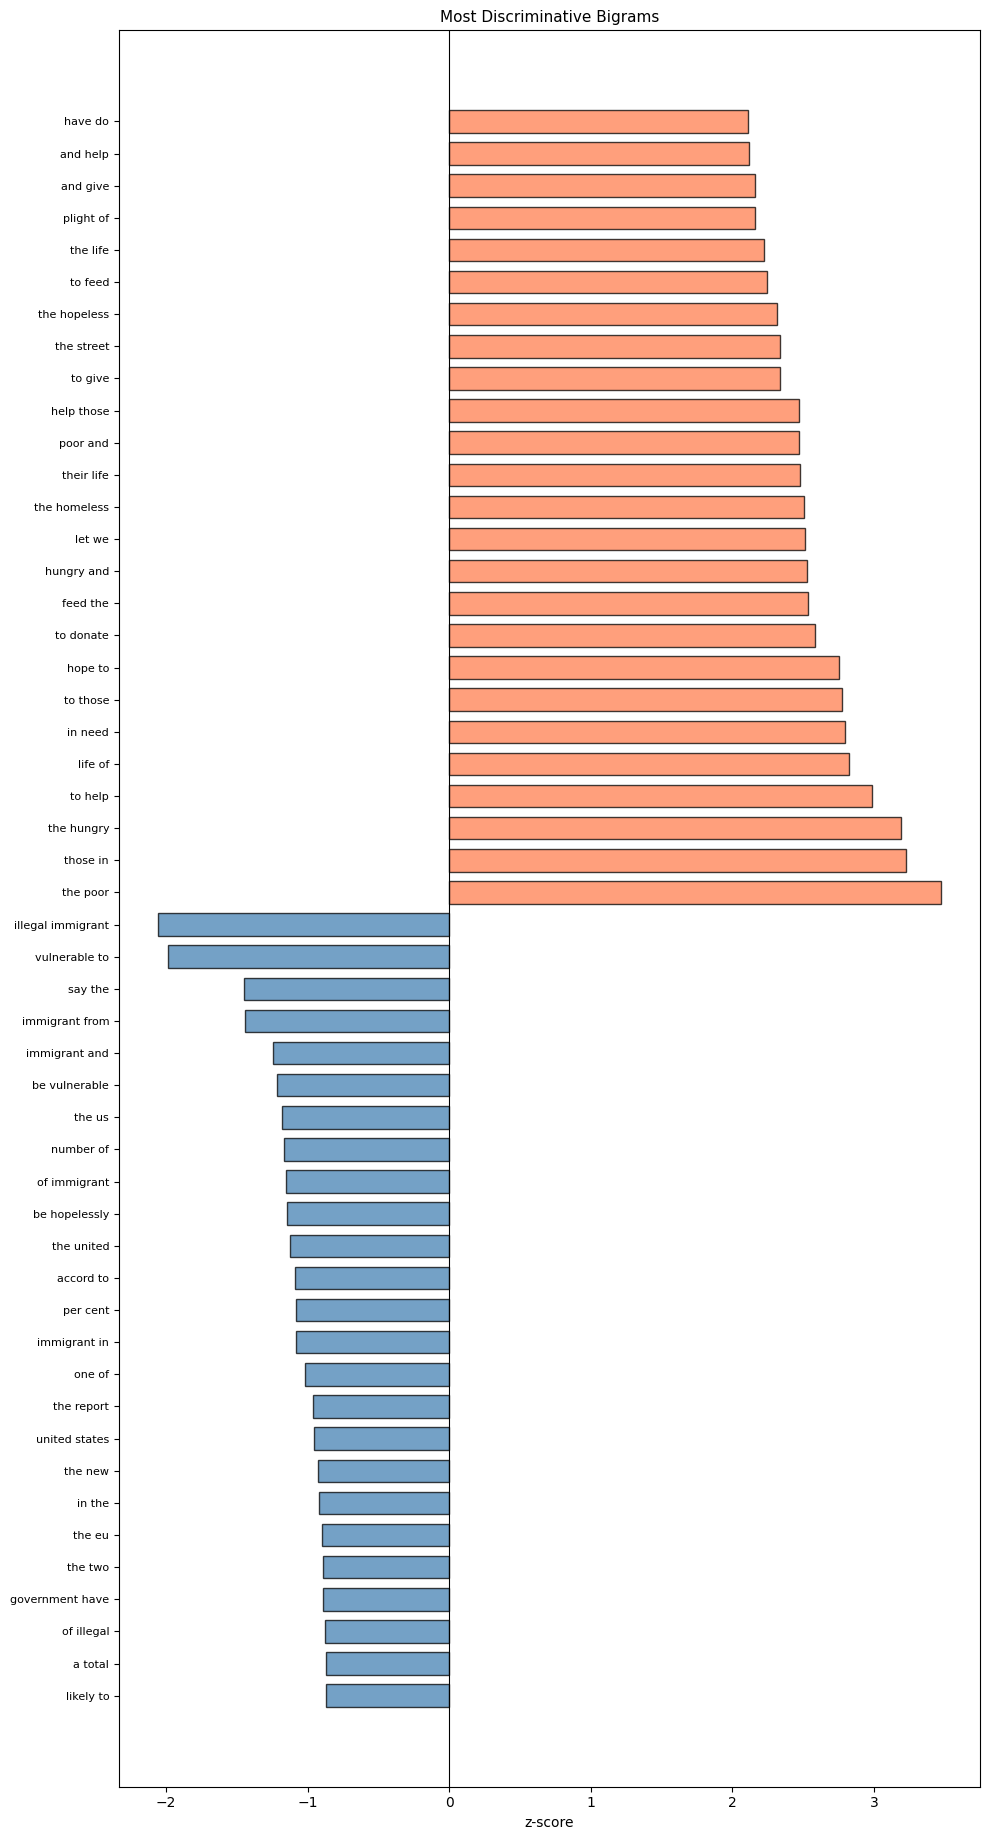

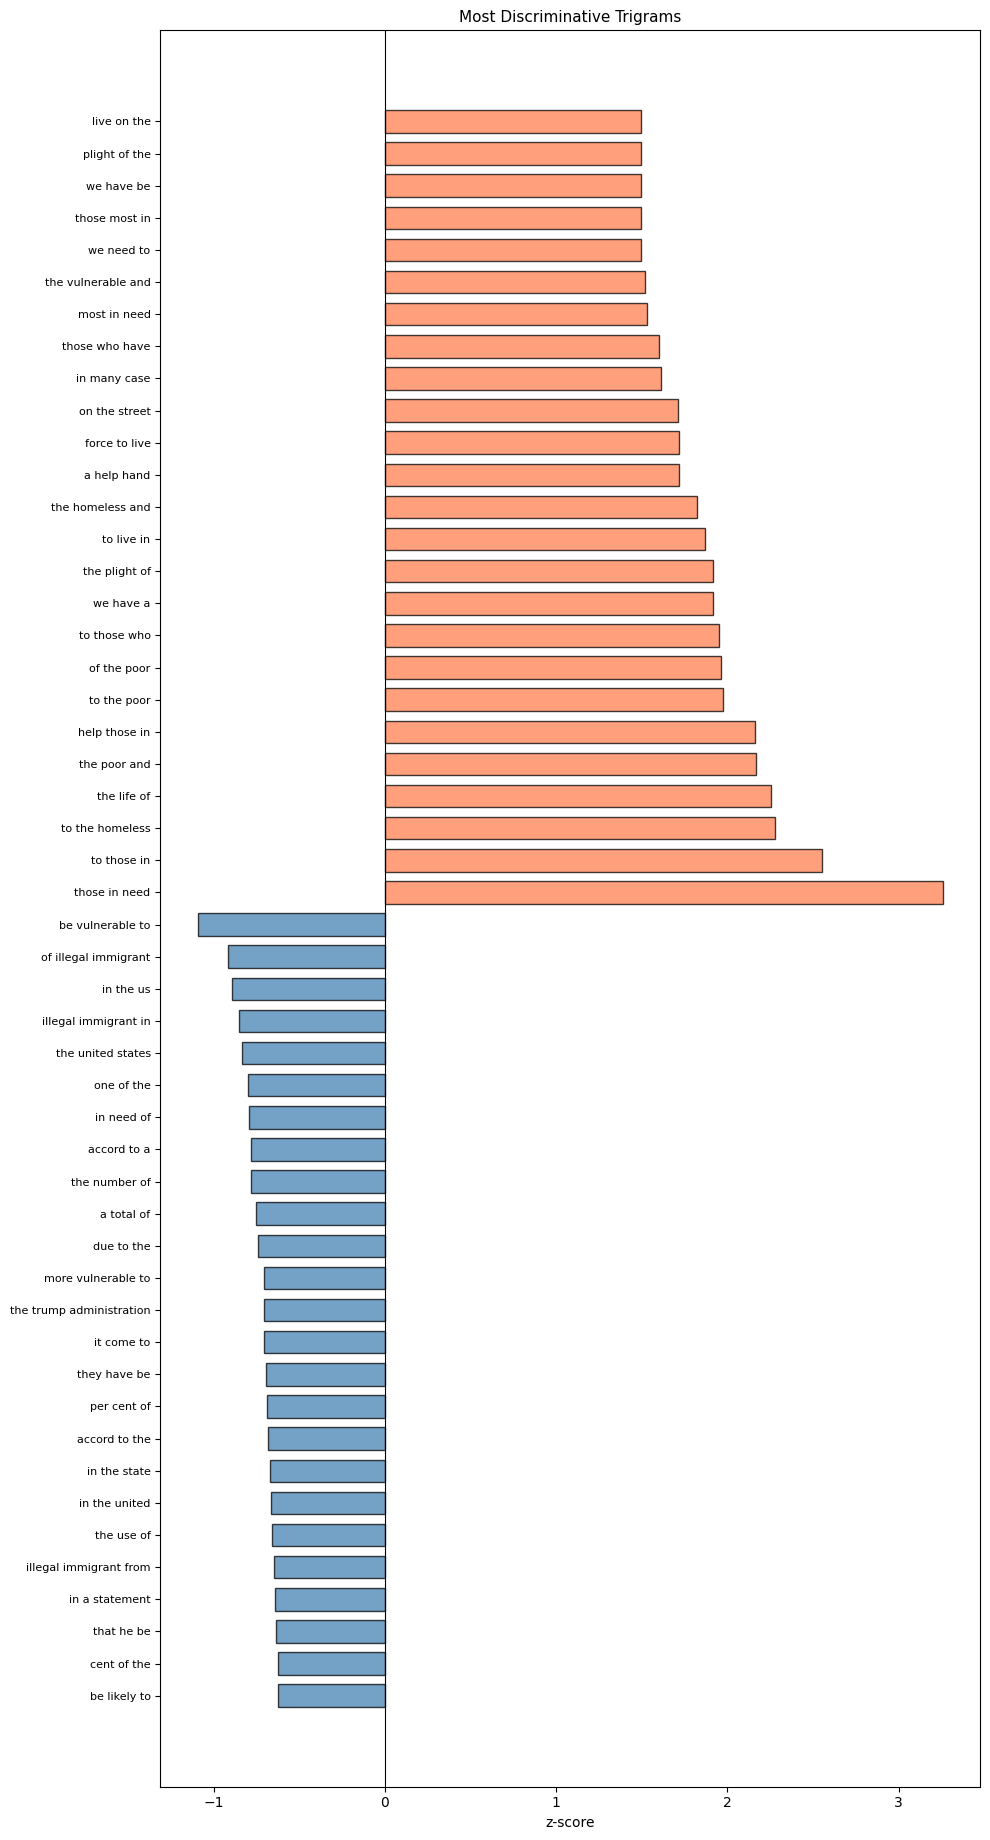

In [14]:
from collections import Counter
import numpy as np

# Fightin' Words: Log-odds ratio with informative Dirichlet prior
# Monroe, Colaresi & Quinn (2008)

SKIP_GRAM_MODE = False

labels = doc_df["label"].values

# Step 1: Count n-gram frequencies per class (lemmatised, no stopwords/punct)
def build_ngram_counts(paras, labels, ns=(1, 2, 3)):
    pos_counts = Counter()
    neg_counts = Counter()
    for para, label in zip(paras, labels):
        if SKIP_GRAM_MODE:
            tokens = [t.lemma_.lower() for t in para
                    if t.is_alpha and not t.is_stop and not t.is_punct and not t.is_space]
            ngrams = []
            for n in ns:
                ngrams.extend([" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)])
        else:
            tokens = [t.lemma_.lower() if t.is_alpha else "###" for t in para]
            ngrams = []
            for n in ns:
                for i in range(len(tokens)-n+1):
                    chunk = tokens[i:i+n]
                    if "###" in chunk: continue # Skip chunks with punct
                    # Optional: Check if chunk contains stopwords
                    ngrams.append(" ".join(chunk))
        if label >= 2:
            pos_counts.update(ngrams)
        else:
            neg_counts.update(ngrams)
    return pos_counts, neg_counts

pos_counts, neg_counts = build_ngram_counts(paras, labels, ns=(1, 2, 3))

# Step 2: Background corpus as informative Dirichlet prior (§3.2)
# α_w = pooled frequency of n-gram w across both classes
bg_counts = pos_counts + neg_counts

MIN_COUNT = 10
scored_ngrams = {w for w, c in bg_counts.items() if c >= MIN_COUNT}
print(f"N-grams with >= {MIN_COUNT} occurrences: {len(scored_ngrams)}")

# Step 3: Log-odds ratio with Dirichlet smoothing (§3.2, Eqs. 14–16)
#   Eq. 14: ω̂_w^(i)  = log( (y_w^(i) + α_w) / (n^(i) + α_0 − y_w^(i) − α_w) )
#   Eq. 15: δ̂_w      = ω̂_w^(pos) − ω̂_w^(neg)
#   Eq. 16: σ²(δ̂_w)  ≈ 1/(y_w^(pos) + α_w) + 1/(y_w^(neg) + α_w)
#   z_w = δ̂_w / √σ²

n_pos = sum(pos_counts.values())
n_neg = sum(neg_counts.values())
alpha_0 = sum(bg_counts.values())  # total Dirichlet concentration (full n-gram set)

log_odds = {}
z_scores = {}
for w in scored_ngrams:
    y_pos = pos_counts[w]
    y_neg = neg_counts[w]
    alpha_w = bg_counts[w]

    omega_pos = np.log((y_pos + alpha_w) / (n_pos + alpha_0 - y_pos - alpha_w))
    omega_neg = np.log((y_neg + alpha_w) / (n_neg + alpha_0 - y_neg - alpha_w))
    delta = omega_pos - omega_neg

    var = (1.0 / (y_pos + alpha_w)) + (1.0 / (y_neg + alpha_w))
    z = delta / np.sqrt(var)

    log_odds[w] = delta
    z_scores[w] = z

# Step 4: Rank by z-score
sorted_pos = sorted(z_scores.items(), key=lambda x: x[1], reverse=True)
sorted_neg = sorted(z_scores.items(), key=lambda x: x[1])

TOP_K = 30
print(f"\n{'='*80}")
print(f"Top {TOP_K} n-grams most associated with POSITIVE (PCL) class:")
print(f"{'='*80}")
print(f"  {'N-gram':<30} {'z-score':>10} {'log-odds':>10} {'pos_freq':>10} {'neg_freq':>10}")
print(f"  {'-'*72}")
for w, z in sorted_pos[:TOP_K]:
    print(f"  {w:<30} {z:>+10.2f} {log_odds[w]:>+10.4f} {pos_counts[w]:>10} {neg_counts[w]:>10}")

print(f"\n{'='*80}")
print(f"Top {TOP_K} n-grams most associated with NEGATIVE (non-PCL) class:")
print(f"{'='*80}")
print(f"  {'N-gram':<30} {'z-score':>10} {'log-odds':>10} {'pos_freq':>10} {'neg_freq':>10}")
print(f"  {'-'*72}")
for w, z in sorted_neg[:TOP_K]:
    print(f"  {w:<30} {z:>+10.2f} {log_odds[w]:>+10.4f} {pos_counts[w]:>10} {neg_counts[w]:>10}")

# Step 5: Visualisation
TOP_VIS = 25
top_pos_items = sorted_pos[:TOP_VIS]
top_neg_items = sorted_neg[:TOP_VIS]

vis_items = list(reversed(top_neg_items)) + top_pos_items
vis_labels = [w for w, _ in vis_items]
vis_zscores = [z for _, z in vis_items]
vis_colours = ["coral" if z > 0 else "steelblue" for z in vis_zscores]

fig, ax = plt.subplots(figsize=(10, len(vis_items) * 0.35 + 1))
y_pos = np.arange(len(vis_items))
ax.barh(y_pos, vis_zscores, color=vis_colours, edgecolor="black", alpha=0.75, height=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(vis_labels, fontsize=8)
ax.axvline(0, color="black", linewidth=0.8)
ax.set_xlabel("z-score (Fightin' Words log-odds ratio)")
ax.set_title("Most Discriminative N-grams: PCL-Positive (coral) vs Non-PCL (blue)", fontsize=11)
plt.tight_layout()
fig.savefig(f"{OUT_PATH}/fightin_words_ngrams.svg", format="svg")
fig.savefig(f"{OUT_PATH}/fightin_words_ngrams.png", dpi=400)
print(f"\nSaved {OUT_PATH}/fightin_words_ngrams.svg and {OUT_PATH}/fightin_words_ngrams.png")
plt.show()

for n, n_label in [(1, "Unigrams"), (2, "Bigrams"), (3, "Trigrams")]:
    n_items_pos = [(w, z) for w, z in sorted_pos if len(w.split()) == n][:TOP_VIS]
    n_items_neg = [(w, z) for w, z in sorted_neg if len(w.split()) == n][:TOP_VIS]
    if not n_items_pos and not n_items_neg:
        continue
    items = list(reversed(n_items_neg)) + n_items_pos
    labels_vis = [w for w, _ in items]
    zs = [z for _, z in items]
    cols = ["coral" if z > 0 else "steelblue" for z in zs]

    fig, ax = plt.subplots(figsize=(10, len(items) * 0.35 + 1))
    ax.barh(np.arange(len(items)), zs, color=cols, edgecolor="black", alpha=0.75, height=0.7)
    ax.set_yticks(np.arange(len(items)))
    ax.set_yticklabels(labels_vis, fontsize=8)
    ax.axvline(0, color="black", linewidth=0.8)
    ax.set_xlabel("z-score")
    ax.set_title(f"Most Discriminative {n_label}", fontsize=11)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{OUT_PATH}/{n}grams_log_odds_ratios.svg", format="svg")
    fig.savefig(f"{OUT_PATH}/{n}grams_log_odds_ratios.png", dpi=400)